## STAT FINAL Note B08705024 資管二 劉鈺祥

In [1]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
from statsmodels.tsa.api import Holt
from statsmodels.tsa.ar_model import AutoReg, AutoRegResults
import math
import statistics as stat
import time
import itertools

## Regression analysis

Simple linear model

$y = \beta_0 + \beta_1x + \epsilon$

y = dependent value

x = independent variable

$\beta_0$ = y-intercept

$\beta_1$ = slope of the line

$\epsilon$ = error variable

Regression Errors: $ e_i = y_i - \hat{y_i}$, where $y_i$ = the actual value and $\hat{y_i}$ = the regression value

The smaller the sum of squared differences, the better the fit of the line to the data

Least Squares Method:

the best line is the one that minimize the sum of squared vertical differences between the points and the line

$Min \sum e_i^2 = \sum(y_i - \hat{y_i})^2 \\ \hat{y_i} = b_0 + b_1x_i$

Sum of Squared Errors(SSE):

$SSE = \sum e_i^2 = \sum(y_i-\hat{y_i})^2$

Requirements:

The error $epsilon$ is a normally distributed random variable

The error $epsilon$ is a random variable with mean of zero

The variance of $epsilon$, denoted by $\sigma^2$, is the same for all values of the independent variable

The values of $epsilon$ is independent

Step of simple Linear Regression

1. Plot the scatter diagram

2. Propose a statistical model

3. Fit the model

4. Residual anaylsis

5. Assess the fitted model

6. Interpretation

7. Apply for prediction

Logistic Regression

The logistic model is of the form:

$f(x) = p = \frac{e^y}{1 + e^y} = \frac{S}{1+S}$

where there is only one predicator:

$y = ln(S) = \beta_0 + \beta_1x + \epsilon$

Generial Logistic Model

$y = ln(S) = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_kx_k + \epsilon$, where S is the odd ratio

$\hat{S} = e^{\hat{y}}$, $P(E) = \frac{\hat{S}}{\hat{S}+1}$

A time series can consist of four components

Long-Term Trend
Cyclical effect
seasonal effect
irregular Variation

Two commonly used time series models

The additive model: $Y_t = T_t + C_t + S_t + I_t$

The multiplicative model: $Y_t = T_t * C_t*S_t*I_t$

Autoregressive model: A regression model in which the independent variables are previous values of the series being forecast

In [2]:
run_test_table = pd.read_excel("Stats_Data/run_test_table.xlsx")
#run_test_table

In [3]:

run_test_table = pd.read_excel("Stats_Data/run_test_table.xlsx")
def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0 
    # Checking for start of new run 
    for i in range(len(l)): 
        # no. of runs 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
            # print(i, runs)
        # no. of positive values 
        if(l[i]) >= l_median: 
            n1 += 1   
        # no. of negative values 
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2

    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2,"\n")
    if(n1>20 or n2>20):
        print('runs_exp = ', runs_exp)
        print('stan_dev = ', stan_dev)
        print('z = ', z)
        print('pval_z = ', pval_z,"\n")
        if(pval_z>=0.05):
            print("Since pvalue is larger than 0.05, we couldn't reject the null hypothesis. Thereofore, the randomness exists.\n\n")
        else:
            print("SInce pvalue is smaller than 0.05, we could reject the null hypothesis. Therefore, the randomness doens't exists.\n\n")
    else: 
        print("Since n1 and n2 is not both larger than 20, we should search for the table\n\n")
        for i in range(0,184):
            if(run_test_table['n1'][i]==n1 and run_test_table['n2'][i]==n2) or (run_test_table['n1'][i]==n2 and run_test_table['n2'][i]==n1) :
                if run_test_table['lower'][i]<runs and run_test_table['upper'][i]>runs:
                    print("Since k1 = %d < %d < k2 = %d, we couldn't reject the null hypothesis. Therefore, the randomness exists.\n\n"%(run_test_table['lower'][i],runs,run_test_table['upper'][i]))
                elif(run_test_table['lower'][i]>=runs):
                    print("Since %d <= k1 = %d, we could reject the null hypothesis. Therefore, the randomness doesn't exist.\n\n"%(run_test_table['lower'][i],runs))
                elif(run_test_table['upper'][i]<=runs):
                    print("Since %d >= k2 = %d, we could reject the null hypothesis. Therefore, the randomness doesn't exist.\n\n"%(runs,run_test_table['upper'][i]))           
    return

def processSubset(y_v, X_v, feature_set):
    X_v_a = sm.add_constant(X_v[list(feature_set)])
    model = sm.OLS(y_v,X_v_a)
    regr = model.fit()
    RSS = regr.rsquared_adj
    return {"model":regr, "RSS":RSS}

def getBest(y_g, X_g, k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X_g.columns, k):
        results.append(processSubset(y_g, X_g, combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmax()]
    toc = time.time()
    return best_model

def ErrMetrix(y_v, f_v):
        y_v_n = pd.DataFrame({'orig': y_v})
        f_v_n = pd.DataFrame({'forecast': f_v})
        err1 = (y_v_n['orig'] - f_v_n['forecast']).dropna().values
        err1p = ((y_v_n['orig'] - f_v_n['forecast'])/ y_v_n['orig']).dropna().values
        MAD = round(np.absolute(err1).mean(),6)
        MSE = round(np.mean(err1 * err1),6)
        RMSE = round(np.sqrt(np.mean(err1 * err1)),6)
        MAPE = round(np.absolute(err1p).mean() * 100, 6)
        return MAD, MSE, RMSE, MAPE
#         print("MAD = ", MAD)
#         print("MSE = ", MSE)
#         print("RMSE = ", RMSE)
#         print("MAPE = ", MAPE, "%")
       




In [41]:
class SimpleRegression():
    def __init__(self,dataframe,yname,xname):
        self.df = dataframe
        self.yname = yname
        self.xname = xname
    def scatter(self):
        plt.scatter(self.df[self.xname],y=self.df[self.yname],color='r')
        plt.title('Scatter Plot for ' + yname)
        plt.xlabel(self.xname)
        plt.ylabel(self.yname)
        _ = sns.regplot(x=self.xname,y=self.yname,data=self.df,color='b',ci=None)
        plt.show()
    def fit_regression(self):
        self.df_result = smf.ols(self.yname+'~'+self.xname, data=self.df).fit()
        self.result_reg = self.df_result
        print(self.df_result.summary())
        print("\n\nEstimated model : y = %0.4f + %0.4f x"%(self.df_result.params[1],self.df_result.params[0]))
        self.residual_analysis()
    def residual_analysis(self):
        self.st, self.data, self.ss = sso.summary_table(self.df_result,alpha=0.05)
        self.SD = self.data[:,10]
    def outlier(self):
        df_out = pd.DataFrame(self.SD,columns=['SD'])
        filter = (df_out['SD']<-2)|(df_out['SD']>2)
        print("Outliers by SD = \n")
        print(df_out['SD'].loc[filter],"\n\n")
    def influential(self):
        x_data = self.df[self.xname].values
        y_data = self.df[self.yname].values
        cov_mat = np.cov(y_data, x_data)
        x_data_bar = x_data.mean()
        data_nobs = len(x_data)
        h_val = 1/data_nobs + (x_data - x_data_bar)**2/(data_nobs-1)/cov_mat[1,1]
        df_h = pd.DataFrame(h_val, columns=["hi"])
        filter = (df_h['hi']>6/data_nobs)
        print("Influential Observations by hi = \n")
        print(df_h['hi'].loc[filter])
    def check_condition(self):
        print("Normality test: \n\n")
        print("Null Hypothesis: distribution is normal \n")
        print("Alternative Hypothesis: distribution is not normal \n\nConduct Shapiro Test: \n")
        stat, p = stats.shapiro(self.SD)
        print('Statistics=%.3f, p=%.3f \n\n'%(stat,p))
        if p<0.05:
            print("Since the p-value %.3f is smaller than 0.05, we could reject the null hypothesis. Therefore, the distribution is nonnormal, the required condition is not satisfy.\n\n"%(p))
        else:
            print("Since the p-value %.3f is larger than 0.05, we couldn't reject the null hypothesis. Therefore, the distribution is normal.\n\n"%(p))
        print("Then test the dependence of the Error variable\n\nNull hypothesis: Randomness Exists\nAlternative hypothesis: Randomness doesn't exists\n")
        SD_median = np.median(self.SD)
        #print("numpy : ",SD_median,'statistics: ',statistics.median(self.SD))
        runsTest(self.SD, SD_median)
        print("\n\nTest Homoscedasticity and Heteroscedasticity\nNull hypothesis: Homoscedasticity\nAlternative hypothesis: Heteroscedasticity\n")
        y_pre = self.data[:, 2]
        plt.plot(y_pre, self.SD , 'o', color ='gray')
        plt.axhline(y=0, color = 'blue')
        plt.axhline(y=2, color = 'red')
        plt.axhline(y=-2, color = 'red')
        plt.title('Standardized Residual Plot')
        plt.xlabel('Odometer')
        plt.ylabel('Standardized Residual')
        plt.show()
    def compare_s_y(self):
        SSE2 = np.sum(self.df_result.resid ** 2)
        df = self.df.shape[0] - 2
        s2_e = SSE2 / df

        print("SSE = ", SSE2)
        print("Degree of freedom = ", df)
        print("s2_e = ", s2_e)
        print("s_e = ", s2_e ** 0.5)
        print("y_bar = ",self.df[self.yname].mean())
    def CI_PI_simple_regression(self,x1, a):
        x = self.df[self.xname]
        y = self.df[self.yname]
        x_new = np.array([1, x1])
        print("make CI and PI predictions at mean of x = ", x1)
        X2 = sm.add_constant(x)
        olsmod = sm.OLS(y, X2)
        result_reg = olsmod.fit()
        y_head = np.dot(result_reg.params, x_new)
        print("y_head = ", y_head)
        (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
        cov_mat1 = np.cov(y, x)
        x_bar = x.mean()
        core1 = (1 / result_reg.nobs + 
             (x1 - x_bar) ** 2 / (result_reg.nobs - 1) / cov_mat1[1,1] ) ** 0.5
        core2 = (1 + 1 / result_reg.nobs + 
             (x1 - x_bar) ** 2 / (result_reg.nobs - 1) / cov_mat1[1,1] ) ** 0.5
        lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core1
        upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core1
        half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core1
        lower_bound2 = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core2
        upper_bound2 = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core2
        half_interval2 = t_plus * (result_reg.mse_resid ** 0.5) * core2
        print("confidence interval for mean: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
        print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
        print("Prediction interval = [%0.4f, %0.4f] " % (lower_bound2, upper_bound2))
        print("    or %0.4f  +- %0.4f" % (y_head, half_interval2))
        CI_PI = np.array([lower_bound, upper_bound, lower_bound2, upper_bound2])
        print("95 percentage Confidence Interval and Prediction Interval at x_bar %.1f (1000 miles)"%(x_bar))
        return 
    def Durbin_Watson_test(self,d_L,d_U):
        print("Two-tail test for First Order Auto-Correlation\n\n")
        print("Null hypothesis: The data are not first-order correlated\n\n")
        print("Alternative hypothesis: The data are first-order correlated\n\n")
        x_square_sum = np.vdot(self.SD, self.SD)
        size = self.SD.size
        x_d = np.zeros((size))
        l_size = size - 1
        for i in range(l_size):
            x_d[i + 1] = self.SD[i + 1] - self.SD[i]
        d = np.vdot(x_d, x_d) / x_square_sum
        print("d = ", d,"\n")
        if d<d_L:
            print("First order correlation exists")
        elif d>=d_L and d<=d_U:
            print("Inconclusive test")
        elif d>d_U and d<4-d_U:
            print("First order correlation does not exist")
        elif d>=4-d_U and d<=4-d_L:
            print("Inconclusive test")
        else:
            print("First order correlation exists")
        return

class MultipleRegression(SimpleRegression):
    def __init__(self,dataframe,yname,xnames):
        self.df = dataframe
        self.yname = yname
        self.xnames = xnames
    def draw_plot(self):
        y_var = self.df[self.yname].values
        for aname in self.xnames:
            x_var = self.df[aname].values
            _ = sns.regplot(x=x_var, y=y_var,data=self.df,color='b',ci=None)
            plt.xlabel(aname)
            plt.ylabel(self.yname)
            plt.show()
        temp = self.xnames
        temp.append(self.yname)
        corr1 = self.df[temp].corr()
        _ = sns.heatmap(corr1, annot=True)
    def fit_multi_regression(self):
        y_data = self.df[self.yname]
        tempname = self.xnames[0]
        X_data_ar = np.array([self.df[tempname]])
        for aname in self.xnames:
            if aname != tempname:
                X_data_ar = np.append(X_data_ar,[self.df[aname]],axis=0)
        #print(X_data_ar)
        X_data_T = X_data_ar.T
        X_data = pd.DataFrame(X_data_T,columns = self.xnames)
        X_data2 = sm.add_constant(X_data)
        olsmod = sm.OLS(y_data, X_data2)
        self.df_result = olsmod.fit()
        self.result_reg = olsmod.fit()
        print(self.df_result.summary())
        super().residual_analysis()
    # reference: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults
    def std_error_y_mean(self):
        print("standard error = ", self.result_reg.mse_resid ** 0.5)
        print("mean of y", self.df[self.yname].mean())
    def get_coefficient(self):
        print("R-squared value : ",self.result_reg.rsquared)
        print("Adjust R-squared value: ", self.result_reg.rsquared_adj)
    def test_validity(self):
        print("Testing model validity \n\n")
        print("Null hypothesis: \u03B21 = ... = \u03B2n = 0\n\n")
        print("Alternative hypothesis: At least one \u03B2i is not equal to zero\n\n")
        print("The f-pvalue = ",self.result_reg.f_pvalue,"\n\n")
        if self.result_reg.f_pvalue<0.05:
            print("Since the f-pvalue is smaller than 0.05, we could reject the null hypothesis. Therefore, at least one \u03B2i is not equal to zero, the model is valid")
        else:
            print("Since the f-pvalue is larger than 0.05, we couldn't reject the null hypothesis. Therefore, the model is not valid.")
            
    def test_params_coefficient(self):
        print("Testing the coefficient of parameters\n\n")
        for i in range(1,self.result_reg.pvalues.size):
            print("Testing parameter ",i,"\n\n")
            print("Null hypothesis: \u03B2%d = 0\n\n"%(i))
            print("Alternative hypothesis: \u03B2%d != 0\n\n"%(i))
            if self.result_reg.pvalues[i] < 0.05:   
                print("Since the p-value is smaller than 0.05, we could reject the null hypothesis. Parameter %d has linear relationship with depentent value\n\n"%i)
            else:
                print("Since the p-value is larger than 0.05, we couldn't reject the null hypothesis. Parameter %d has no linear relationship with depentent value\n\n"%i)
                
    def CI_PI_regression(self, x1, a):
        print("make CI and PI prediction at mean of x = ", x1[1:])
        yval = self.df[self.yname]
        tempname = self.xnames[0]
        xdata = np.array([self.df[tempname]])
        for aname in self.xnames:
            if aname != tempname:
                xdata = np.append(xdata,[self.df[aname]],axis=0)
        X_data_T = xdata.T
        X_data2 = sm.add_constant(X_data_T)
        olsmod = sm.OLS(yval, X_data2)
        result_reg = olsmod.fit()
        y_head = np.dot(result_reg.params, x1)
        print("y_head = ", y_head)
        (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
        core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5
        lower_bound = y_head +  t_minus * core1
        upper_bound = y_head +  t_plus * core1
        print("confidence interval of mean = [%0.4f, %0.4f] " % (lower_bound, upper_bound))
        core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
        lower_bound2 = y_head +  t_minus * core2
        upper_bound2 = y_head +  t_plus * core2
        print("Prediction interval = [%0.4f, %0.4f] " % (lower_bound2, upper_bound2))
        CI_PI = np.array([lower_bound, upper_bound, lower_bound2, upper_bound2])
        return CI_PI

    def outliers_and_influential_observations(self):
        df_out = pd.DataFrame(self.SD,columns = ['SD'])
        filter = (df_out['SD'] < -2) | (df_out['SD'] > 2)
        print("Outliers by SD = \n")
        print(df_out['SD'].loc[filter])
        tempname = self.xnames[0]
        xdata = np.array([self.df[tempname]])
        for aname in self.xnames:
            if aname != tempname:
                xdata = np.append(xdata,[self.df[aname]],axis=0)
        X_data_T = xdata.T
        X = sm.add_constant(X_data_T)
        H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))
        self.df['hii'] = np.diagonal(H)
        df_hii_h = pd.DataFrame(self.df['hii'])
        k = self.result_reg.df_model
        n = len(df_hii_h['hii'])
        h_level = 3 * (k+1) / n 
        print("h_level = ", h_level)
        print(" \n")
        filter = (df_hii_h['hii'] > h_level )
        print("Influential Observations by hi = \n")
        print(self.df['hii'].loc[filter])
    

    def multicollinearity_plot(self):
        df_heat = self.df[xnames]
        corr1 = df_heat.corr()
        _ = sns.heatmap(corr1, annot=True)
        return 
    # get new regression class instance
    def turn_dummy(self,xname):
        unique_elements = np.unique(self.df[xname])
        color_list = sns.color_palette("hls", 8)
        label = []
        for aname in self.xnames:
            if aname!=xname:
                for index, unique in enumerate(unique_elements):
                    df_temp = self.df[self.df[xname]==unique]
                    _ = sns.regplot(x=aname, y = self.yname,data=df_temp,color=color_list[index],ci=None)
                    label.append(xname + ' = ' + str(unique))
        plt.legend(labels=label)
        plt.title('Scatter Plot for ' + self.yname)
        plt.xlabel(aname)
        plt.ylabel(self.yname)
        plt.show()
        color_dummy = pd.get_dummies(self.df[xname],prefix=xname)
        new_df = pd.concat([self.df,color_dummy],axis=1)
        new_xnames = xnames
        new_xnames.remove(xname)
        interval = new_xnames
        new_xnames = np.append(new_xnames,color_dummy.columns[:color_dummy.columns.size-1])
        dummy = color_dummy.columns[:color_dummy.columns.size-1]
        print(dummy)
        return GeneralRegression(new_df,self.yname,new_xnames,interval,dummy)
    def get_info(self):
        print(self.df)
        print(self.xnames)
        print(self.yname)
    def forward_selection(self):
        input_df = self.df
        depv = self.yname
        indepv = self.xnames
        selected = []
        candidates = indepv.copy()
        best_adjr2 = -1
        best_subset = []
        while len(candidates) > 0:
            print("Current Candidates: ", candidates)
            tmp_indep_subset = []
            tmp_model_adjr = []
            tmp_model_nindep = []
            for acandidate in candidates:
                tmplist = selected.copy()
                tmplist.append(acandidate)
                modelstr = depv + " ~ " + "+".join(tmplist)
                result6tmp = smf.ols(modelstr, data=input_df).fit()
                tmp_indep_subset.append(tmplist)
                tmp_model_adjr.append(result6tmp.rsquared_adj)
                tmp_model_nindep.append(len(tmplist))
            tmp_adjr2 = np.array(tmp_model_adjr)
            tmpind = tmp_adjr2.argmax()
            this_adjr2 = tmp_adjr2[tmpind]
            selected = tmp_indep_subset[tmpind]
            if this_adjr2 <= 0:
                raise("Encounterd negative Adj R2. Stop.")
            print("===============")
            print("Current best model: ", selected)
            print("Current best AdjR2: ", this_adjr2)
            if this_adjr2 > best_adjr2:
                #print(" best result updated")
                best_adjr2 = this_adjr2
                best_subset = selected
            candidates = set(candidates) - set(selected)
            candidates = list(candidates)
        print("best_adjr2 = ", best_adjr2)
        print("best_subset = ", best_subset)
        modelstr = depv + " ~ " + "+".join(best_subset)
        result6b = smf.ols(modelstr, data=input_df).fit()
        print(result6b.summary()) 
    def best_subset(self):
        y_var = self.df[self.yname]
        tempname = self.xnames[0]
        X_data_ar = np.array([self.df[tempname]])
        for aname in self.xnames:
            if aname != tempname:
                X_data_ar = np.append(X_data_ar,[self.df[aname]],axis=0)
        X_data_T = X_data_ar.T
        X_var = pd.DataFrame(X_data_T, columns = self.xnames)
        models_best = pd.DataFrame(columns=["RSS", "model"])
        tic = time.time()
        for i in range(1,len(self.xnames)+1):
            models_best.loc[i] = getBest(y_var, X_var, i)
        toc = time.time()
        print("Total elapsed time:", (toc-tic), "seconds.")
        Fb = models_best[models_best['RSS']==models_best.RSS.max()].index.values
        print(models_best.loc[Fb[0], "model"].summary())

        
class GeneralRegression(MultipleRegression):
    def __init__(self,df,yname,xnames,interval,dummy):
        self.df = df
        self.yname = yname
        self.xnames = xnames
        self.interval = interval
        self.dummy = dummy
    def draw_plot(self):
        for dum in self.dummy:
            for xname in self.interval:
                df_new_1 = self.df[self.df[dum]==1]
                df_new_2 = self.df[self.df[dum]==0]
                _ = sns.regplot(x=xname, y=self.yname, data=df_new_1, color = 'red',ci=None)
                _ = sns.regplot(x=xname, y=self.yname, data=df_new_2, color ='blue',ci=None)
                plt.legend(labels=[dum + ' = 1',dum+' = 2'])
                plt.title("Scatter Plot for "+ self.yname)
                plt.xlabel(xname)
                plt.ylabel(self.yname)
                plt.show()
        temp = self.interval
        temp.append(self.yname)
        df_heat = self.df[temp]
        corr1 = df_heat.corr()
        _ = sns.heatmap(corr1, annot=True)
        
    def get_info(self):
        print(self.df)
        print(self.yname)
        print(self.xnames)
        print(self.interval)
        print(self.dummy)
        
class LogisticRegression():
    def __init__(self,df,yname,xnames):
        self.df = df
        self.yname = yname
        self.xnames = xnames
    def fit_logistic_regression(self):
        y_data = self.df[self.yname]
        tempname = self.xnames[0]
        X_data_ar = np.array([self.df[tempname]])
        for aname in self.xnames:
            if aname != tempname:
                X_data_ar = np.append(X_data_ar,[self.df[aname]],axis=0)
        X_data_T = X_data_ar.T
        X_data = pd.DataFrame(X_data_T,columns=xnames)
        X_data = sm.add_constant(X_data)
        logit_model = sm.Logit(y_data,X_data)
        self.result_reg = logit_model.fit()
        print(self.result_reg.summary2())
    def draw_plot(self):
        temp = self.xnames
        temp.append(yname)
        df_lr = self.df[temp]
        corr1 = df_lr.corr()
        _ = sns.heatmap(corr1, annot=True)
    def predict(self,new_candidates):
        df_pred = pd.DataFrame()
        for index, xname in enumerate(self.xnames):
            df_pred[xname] = new_candidates[index]
        df_pred = sm.add_constant(df_pred)
        y_pred = self.result_reg.predict(df_pred)
        S_hat = np.exp(y_pred)
        P = S_hat/(S_hat+1)
        Result_ar = np.array([y_pred,S_hat,P])
        Result_df = pd.DataFrame(Result_ar.T, columns=['yhat','S_hat','Probability'])
        df_pred = pd.concat([df_pred, Result_df],axis=1)
        display(df_pred)
        
        
class TimeSeries(SimpleRegression):
    def __init__(self,df,yname,xnames,quartername):
        self.df = df
        self.yname = yname
        self.xnames = xnames
        self.quarter = quartername
        self.des_df = pd.DataFrame()
        self.Ma_index = pd.DataFrame()
    def add_time(self):
        self.df_len = self.df.shape[0]
        time = []
        for i in range(0,self.df_len):
            time.append(i)
        self.xname = 'time'
        self.df[self.xname] = time
    def ma(self, p):
        y_v = self.df[self.yname]
        ma_p_a = np.zeros(len(y_v) + 1)
        ma_p_a[:] = np.nan
        mvlen = p
        for i in range(mvlen, len(y_v) + 1):
            ma_p_a[i] = np.mean(y_v[i-mvlen: i])
        t1 = range(0, len(y_v) + 1) + np.ones((len(y_v) + 1))
        org_data = np.append(y_v, [np.nan])
        ma_df_p = pd.DataFrame({'time':t1, 'orig': org_data, 'ma_forecast': ma_p_a})
        plt.plot(t1,org_data)
        plt.plot(t1,ma_p_a)
        plt.ylim(min(self.df[self.yname])*0.8,max(self.df[self.yname])*1.2)
        plt.legend(labels=['org','forecast'])
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title('Line Chart for '+self.yname+' by MA '+str(p))
        plt.show()
        self.ma_df_p = ma_df_p
        #return ma_df_p
    def ExSm(self,a):
        y_v = self.df[self.yname]
        es_df = pd.DataFrame({'orig': y_v})
        es_df['es_res'] = es_df['orig'].ewm(alpha = a, adjust= False).mean()
        es_al_a = np.zeros(len(y_v) + 1)
        es_al_a[0] = es_df['es_res'][0]
        es_al_a[1] = es_df['es_res'][0]
        for i in range(2, len(y_v) + 1):
            es_al_a[i] = es_df['es_res'][i-1]
        t1 = range(0, len(y_v) + 1) + np.ones((len(y_v) + 1))
        org_data = y_v.tolist()
        es_df_e = pd.DataFrame({'time':t1, 'orig': np.array(org_data + [float('nan')]), 'es_forecast': es_al_a})
        plt.plot(t1, es_df_e['orig'])
        plt.plot(t1,es_al_a)
        plt.ylim(min(self.df[self.yname])*0.8,max(self.df[self.yname])*1.2)
        plt.legend(labels=['org','forecast'])
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title('Line Chart for '+self.yname+' by ES('+str(a)+")")
        plt.show()
        self.es_df_e = es_df_e
        #return es_df_e
    def ESM(self,a, b, f0, t0, p):
        y_v = self.df[self.yname]
        esm_a = np.array(y_v)
        esm_model = Holt(esm_a, initialization_method='known', initial_level = f0, initial_trend = t0).fit(smoothing_level=a, smoothing_trend=b, optimized=False)
        esm_fit = esm_model.fittedvalues
        esm_fcast = esm_model.forecast(p)
        esm_ab_a = np.zeros(len(y_v) + p + 1)
        esm_ab_a[0] = f0 + t0
        for i in range(1, len(y_v) + 1):
            esm_ab_a[i] = esm_fit[i-1]
        for i in range(len(y_v) + 1, len(y_v) + p + 1):
            esm_ab_a[i] = esm_fcast[i-len(y_v)-1]
        t1 = range(0, len(y_v) + p + 1)
        Ini_v = f0 + t0
        W_ini_v = np.append(Ini_v, y_v)
        org_data = np.append(W_ini_v, [np.nan]*p)
        wsm_df_ab = pd.DataFrame({'time':t1, 'orig': org_data, 'esm_forecast': esm_ab_a})
        self.wsm_df_ab = wsm_df_ab
        plt.plot(t1,org_data)
        plt.plot(t1,esm_ab_a)
        plt.ylim(min(esm_ab_a)*0.9,max(esm_ab_a)*1.1)
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title('Line Chart for '+self.yname +' by ESM('+str(a)+(',')+str(b)+(',')+str(f0)+(',')+str(t0)+')')
        #return wsm_df_ab
    
    def Err_compare(self):
        f_p = len(self.df[self.yname])
        orig_ = self.df[self.yname][3:f_p]
        ma_result = self.ma_df_p
        ma_ = np.array(ma_result['ma_forecast'][3:f_p])
        es_result = self.es_df_e
        es_ = np.array(es_result['es_forecast'][3:f_p])
        esm_result = self.wsm_df_ab
        esm_ = np.array(esm_result['esm_forecast'][4:f_p+1])
        MA_Err_M = ErrMetrix(orig_, ma_)
        ES_Err_M = ErrMetrix(orig_, es_)
        ESMAB_Err_M = ErrMetrix(orig_, esm_)
        ErrM_id = ['MAD', 'MSE', 'RMSE', 'MAPE']
        Compare_ErrM = np.array([ErrM_id, MA_Err_M, ES_Err_M, ESMAB_Err_M])
        Compare_df = pd.DataFrame(Compare_ErrM.T, columns = ['ErrM', 'MA('+str(ma_p)+')', 'ES('+str(ex_a)+')', 'ESM('+str(es_a)+','+str(es_b)+')'])
        display(Compare_df)
        
    def cmv(self, mvlen):
        n = self.df.shape[0]
        ts = np.zeros(n)
        
        ts[:] = np.nan
        halfwin = int((mvlen - 1) / 2)
        for i in range(halfwin, n - halfwin):
            ts[i] = np.mean(self.df[self.yname][(i-halfwin): (i+halfwin+1)])
        #print(ts)
        ts_df = pd.DataFrame({'orig': self.df[self.yname], 'ma'+str(mvlen)+'_smooth': ts})
        t = range(0,n)
        plt.plot(t, self.df[self.yname])
        plt.plot(t, ts)
        plt.ylim(min(self.df[self.yname])*0.9, max(self.df[self.yname])*1.1)
        plt.legend(labels=['org', 'MA('+str(mvlen)+')'])
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title(self.yname +' by Moving avaerage')
        plt.show()
        return 
    
    def SI_MA(self,n):
        y_v = self.df[self.yname]
        length = len(y_v)
        y_v_MA_a = np.zeros(length)
        y_v_MA_a[:] = np.nan
        mvlen = n
        if n % 2 == 0:
            halfwin = int(mvlen / 2)
            y_v_MA_ta = np.zeros(length)
            for i in range(halfwin, length - halfwin + 1):
                y_v_MA_ta[i] = np.mean(y_v[(i-halfwin): (i+halfwin)])
            for ii in range(halfwin, length - halfwin):
                y_v_MA_a[ii] = np.mean(y_v_MA_ta[(ii): (ii+2)])
        else:
            halfwin = int((mvlen - 1) / 2)
            for i in range(halfwin, length - halfwin):
                y_v_MA_a[i] = np.mean(y_v[(i-halfwin): (i+halfwin+1)])
        SI_MA_a = np.zeros(len(y_v))
        SI_MA_a[:] = np.nan
        SI_MA_a = y_v / y_v_MA_a    
        SI_id_s = np.arange(1,len(y_v)+1)
        SI_id = SI_id_s - np.floor(SI_id_s / n) * n
        SI_id[np.where((SI_id[:] == 0))] = n
        SI_MA_a_df = pd.DataFrame({'SIMA': SI_MA_a, 'SIid': SI_id})
        SI_MA_u = np.zeros(n)
        for j in range(1,n+1):
            SI_MA_u[j-1] = SI_MA_a_df['SIMA'][SI_MA_a_df['SIid'] == j].dropna().mean()  
        SI_MA = SI_MA_u / sum(SI_MA_u) * n
        print('Seasonal Index:', SI_MA)   
        y_v_SI_MA = np.zeros(len(y_v))
        DSI_y_v = np.zeros(len(y_v))
        for k in range(0,len(y_v)):
            Idd = int(SI_MA_a_df['SIid'][k] - 1)
            y_v_SI_MA[k] = SI_MA[Idd]
            DSI_y_v[k] = y_v[k] / SI_MA[Idd]
        SI_MA_result_a = np.array([SI_MA_a_df['SIid'], y_v_SI_MA, y_v, DSI_y_v])
        SI_MA_result_df = pd.DataFrame(SI_MA_result_a.T, columns = ['SID', 'SeaIdx', 'orig', 'Des_D'])
        #return SI_MA, SI_MA_result_df
        df_len = self.df.shape[0]
        time = []
        for l in range(0,df_len):
            time.append(l)
        plt.plot(time, SI_MA_result_df['orig'])
        plt.plot(time, SI_MA_result_df['Des_D'])
        plt.legend(labels=['org', 'Des_data'])
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title('Sales by Moving Average ('+str(mvlen)+') Seasonal Index')
        plt.show()
        self.des_df = SI_MA_result_df
        self.Ma_index = SI_MA
        self.des_df['time'] = time
        return SI_MA, SI_MA_result_df
    
    def des_fit_regression(self):
        y_data = self.des_df['Des_D']
        X_data_ar = np.array([self.des_df['time']])
        X_data_ar_T = X_data_ar.T
        X_data = pd.DataFrame(X_data_ar_T, columns = ['time'])
        X_data = sm.add_constant(X_data)
        olsmod = sm.OLS(y_data, X_data)
        self.result_reg = olsmod.fit()
        self.result_reg_ma = self.result_reg
        self.df_result = self.result_reg
        print(self.result_reg.summary())
        super().residual_analysis()
        y_pre = self.data[:, 2]
        self.ma_sea_pre = y_pre*self.des_df['SeaIdx']
        print(self.des_df)
        plt.plot(self.des_df['time'], self.des_df['orig'])
        plt.plot(self.des_df['time'], self.des_df['Des_D'])
        plt.plot(self.des_df['time'], y_pre)
        plt.legend(labels=['org', 'Des_data', 'Line_pre'])
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title(self.yname+' by Moving Average Seasonal Index')
        plt.show()
        
    def SI_Forecast(self,New_t,flag = False):
        des_pre = self.data[:,2]
        Sea_pre = des_pre * self.des_df['SeaIdx']
        #New_t = np.array([12, 13, 14, 15])
        Total_t = np.append(self.des_df['time'], New_t)
        New_t = sm.add_constant(New_t)
        MA_des_pre_New_t = self.result_reg.predict(New_t)
        print('New Des Prediction', MA_des_pre_New_t)
        MA_Sea_pre_New_t = MA_des_pre_New_t * self.Ma_index
        print('New Prediction', MA_Sea_pre_New_t)
        New_Nan = np.zeros(New_t.shape[0])
        New_Nan[:] = np.nan
        MA_New_orig = np.append(self.des_df['orig'], New_Nan)
        MA_New_Des_D = np.append(self.des_df['Des_D'], New_Nan)
        MA_New_des_pre = np.append(des_pre, MA_des_pre_New_t)
        MA_New_Sea_pre = np.append(Sea_pre, MA_Sea_pre_New_t)
        MA_S_a = np.array([Total_t, MA_New_orig, MA_New_Des_D, MA_New_des_pre, MA_New_Sea_pre])
        MA_S_df = pd.DataFrame(MA_S_a.T, columns=['time', 'org', 'Des_data', 'Line_pre', 'Seasonal Pre'])
        display(MA_S_df)
        
        plt.plot(Total_t, MA_New_orig)
        plt.plot(Total_t, MA_New_Des_D)
        plt.plot(Total_t, MA_New_des_pre)
        plt.plot(Total_t, MA_New_Sea_pre)
        plt.ylim(min(self.des_df['orig'])*0.9, max(self.des_df['orig'])*1.1)
        plt.legend(labels=['org', 'Des_data', 'Line_pre', 'Seasonal Pre'])
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title(self.yname+ 'by Moving Average Seasonal Index')
        plt.show()
    def SI_LR(self, n):
        y_v = self.df[self.yname]
        y_data = y_v
        X_data_ar = np.arange(1, len(y_v)+1)
        X_data_T = X_data_ar.T
        X_data = pd.DataFrame(X_data_T,columns = ['Time'])
        X_data = sm.add_constant(X_data)
        olsmod = sm.OLS(y_data, X_data)
        result_reg = olsmod.fit()
        self.df_result = result_reg
        st, data, ss2 = sso.summary_table(result_reg, alpha=0.05)
        y_v_LR_a = data[:, 2]
        SI_LR_a = y_v / y_v_LR_a
        SI_id_s = np.arange(1,len(y_v)+1)
        SI_id = SI_id_s - np.floor(SI_id_s / n) * n
        SI_id[np.where((SI_id[:] == 0))] = n
        SI_LR_a_df = pd.DataFrame({'SILR': SI_LR_a, 'SIid': SI_id})
        SI_LR_u = np.zeros(n)
        for j in range(1,n+1):
            SI_LR_u[j-1] = SI_LR_a_df['SILR'][SI_LR_a_df['SIid'] == j].dropna().mean()
        SI_LR = SI_LR_u / sum(SI_LR_u) * n
        print('Seasonal Index:', SI_LR)
        print('\n')
        y_v_SI_LR = np.zeros(len(y_v))
        DSI_y_v = np.zeros(len(y_v))
        for k in range(0,len(y_v)):
            Idd = int(SI_LR_a_df['SIid'][k] - 1)
            y_v_SI_LR[k] = SI_LR[Idd]
            DSI_y_v[k] = y_v[k] / SI_LR[Idd]
#         print('Deseasonalized Data:', DSI_y_v)
        SI_LR_result_a = np.array([SI_LR_a_df['SIid'], y_v_SI_LR, y_v, DSI_y_v])
        SI_LR_result_df = pd.DataFrame(SI_LR_result_a.T, columns = ['SID', 'SeaIdx', 'orig', 'Des_D'])
        self.des_df_lr = SI_LR_result_df
        self.Lr_index = SI_LR
        #display(ch20_ts3_LR_Result)
        t_r = np.arange(0, len(self.df[self.yname]), 1)
        self.des_df_lr['time'] = t_r
        plt.plot(t_r, SI_LR_result_df['orig'])
        plt.plot(t_r, SI_LR_result_df['Des_D'])
        plt.legend(labels=['org', 'Des_data'])
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title(self.yname + ' deseasonalize')
        plt.show()
        return SI_LR, SI_LR_result_df
    def des_fit_regression_lr(self):
        y_data = self.des_df_lr['Des_D']
        X_data_ar = np.array([self.des_df_lr['time']])
        X_data_ar_T = X_data_ar.T
        X_data = pd.DataFrame(X_data_ar_T, columns = ['time'])
        X_data = sm.add_constant(X_data)
        olsmod = sm.OLS(y_data, X_data)
        self.result_reg = olsmod.fit()
        self.result_reg_lr = self.result_reg
        self.df_result = self.result_reg
        print(self.result_reg.summary())
        super().residual_analysis()
        y_pre = self.data[:, 2]
        self.lr_sea_pre = y_pre*self.des_df_lr['SeaIdx']
        print(self.des_df_lr)
        plt.plot(self.des_df_lr['time'], self.des_df_lr['orig'])
        plt.plot(self.des_df_lr['time'], self.des_df_lr['Des_D'])
        plt.plot(self.des_df_lr['time'], y_pre)
        plt.legend(labels=['org', 'Des_data', 'Line_pre'])
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title(self.yname+' by Moving Average Seasonal Index')
        plt.show()
    def SI_LR_Forecast(self,New_t,flag =False):
        temp = self.des_df
        temp1 = self.Ma_index
        self.Ma_index = self.Lr_index
        self.des_df = self.des_df_lr
        self.SI_Forecast(New_t,flag)
        self.des_df = temp
        self.Ma_index = temp1
    
    def dummy_SI(self):
        Quarter_dummy = pd.get_dummies(self.df[self.quarter], prefix = 'Quarter')
        self.df_dummy = pd.concat([self.df, Quarter_dummy], axis = 1)
        y_data = self.df[self.yname]
        td_r = np.arange(0, len(self.df[self.yname]), 1)
        X_data_ar = np.array([td_r])
        for q  in Quarter_dummy.columns[:Quarter_dummy.columns.size -1]:
            X_data_ar = np.concatenate((X_data_ar,np.array([self.df_dummy[q]])),axis=0)
        #X_data_ar = np.array([td_r, self.df_dummy['Quarter_1'], self.df_dummy['Quarter_2'], self.df_dummy['Quarter_3']])
        #X_data_ar = np.array((td,dummy_ar),axis=0)
        X_data_T = X_data_ar.T
        dumname = Quarter_dummy.columns[:Quarter_dummy.columns.size -1]
        X_data = pd.DataFrame(X_data_T, columns = ['time', 'Quarter_1', 'Quarter_2', 'Quarter_3'])
        X_data = sm.add_constant(X_data)
        olsmod = sm.OLS(y_data, X_data)
        self.result_reg = olsmod.fit()
        self.result_reg_dummy = self.result_reg
        print(self.result_reg.summary())
        self.st, self.data, self.ss2 = sso.summary_table(self.result_reg, alpha=0.05)
        y_pre = self.data[:, 2]
        self.dummy_pre = y_pre
        self.SD = self.data[:, 10]
        print('Fitted Values', y_pre)
        plt.plot(td_r, self.df[self.yname])
        plt.plot(td_r, y_pre)
        plt.legend(labels=['org', 'Line_pre'])
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title(self.yname+' by LR Dummy Variables')
        plt.show()
        
    def dummy_forecast(self,New_t,flag = False):
        y_pre = self.data[:,2]
        td_r = np.arange(0, len(self.df[self.yname]), 1)
        Total_t = np.append(td_r, New_t[:,0])
        New_t = sm.add_constant(New_t)
        pre_New_t = self.result_reg.predict(New_t)
        print('New Dummy Season Prediction', pre_New_t)
        New_Nan = np.zeros(New_t.shape[0])
        New_Nan[:] = np.nan
        New_orig = np.append(self.df[self.yname], New_Nan)
        New_pre = np.append(y_pre, pre_New_t)
        plt.plot(Total_t, New_orig)
        plt.plot(Total_t, New_pre)
        plt.legend(labels=['org', 'Line_pre'])
        plt.xlabel('time')
        plt.ylabel(self.yname)
        plt.title(self.yname + ' by LR Dummy Variables')
        plt.show()
        
    def SI_Error_compare(self):
        #print('Error Metrics for Seasonal Index by Moving Average')
        MA_Err_M = ErrMetrix(self.df[self.yname], self.ma_sea_pre)
        #print('\n')
        #print('Error Metrics for Seasonal Index by LR')
        LR_Err_M = ErrMetrix(self.df[self.yname], self.lr_sea_pre)
        #print('\n')
        #print('Error Metrics for LR Dummy')
        DM_Err_M = ErrMetrix(self.df[self.yname], self.dummy_pre)
        ErrM_id = ['MAD', 'MSE', 'RMSE', 'MAPE']
        ErrM_a = np.array([ErrM_id, MA_Err_M, LR_Err_M, DM_Err_M])
        #print(self.df[self.yname],self.ma_sea_pre,self.lr_sea_pre,self.dummy_pre)
        ErrM_df = pd.DataFrame(ErrM_a.T, columns = ['ErrM', 'SIMA', 'SILR', 'Dummy'])
        print('dataset:')
        display(ErrM_df)

class Autoregressive(SimpleRegression):
    def __init__(self,df,yname):
        self.df = df
        self.yname = yname
    def draw_plot(self,xname):
        y_var = self.df[self.yname].values
        x_var = self.df[xname].values
        plt.plot(self.df[xname],self.df[self.yname])
        _ = sns.regplot(x=x_var, y= y_var, data=self.df,color='red',ci=None,scatter = None)
        plt.title('Line Plot for '+self.yname+' against '+ xname)
        plt.xlabel(xname)
        plt.ylabel(self.yname)
        plt.show()
    def draw_shift(self,p = 1):
        self.df['time_shift'] = self.df[self.yname].shift(periods = p)
        df_temp = self.df.dropna()
        self.xname = 'time_shift'
        sns.regplot(x=self.xname,y=self.yname,data=df_temp,color='blue',ci=None)
        plt.title('Scatter Plot for ' + self.yname)
        plt.xlabel(self.xname)
        plt.ylabel(self.yname)
        plt.show()
    def autoregression_model(self,p=1,trends='c'):
        mod = AutoReg(self.df[self.yname],p,old_names=False,trend=trends)
        self.result_reg = mod.fit()
        self.df_result = self.result_reg
        print(self.result_reg.summary())
        print(AutoRegResults(self.df_result))
        #super().residual_analysis()
#     def autoregression_forecast(self):
#         Id = len(self.df[self.xname]) - 1
#         New_data = np.array([1, self.df[self.xname][Id] ])
#         print('New_data : ',New_data)
#         New_pre = self.result_reg.predict(New_data)
#         #print('hi',self.result_reg.predict(New_data))
#         #print("hi")
#         print('New Predictio: ',New_pre)
    def autoregression_model_t(self):
        df_temp = self.df.dropna()
        t = np.arange(0, df_temp.shape[0], 1)
        y_data = df_temp[self.yname].values
        X_data_ar = np.array([t, df_temp[self.xname].values])
        X_data_T = X_data_ar.T
        X_data = pd.DataFrame(X_data_T,columns = ['time', self.xname])
        X_data = sm.add_constant(X_data)
        olsmod = sm.OLS(y_data, X_data)
        self.result_reg = olsmod.fit()
        self.df_result = self.result_reg
        self.residual_analysis()
        print(self.result_reg.summary())


In [5]:
df_auto_regression = pd.read_excel('Stats_Data/Autoregression_example_1.xlsx')
#df_auto_regression


In [42]:
Auto_1 = Autoregressive(df_auto_regression,'Percent_Change')

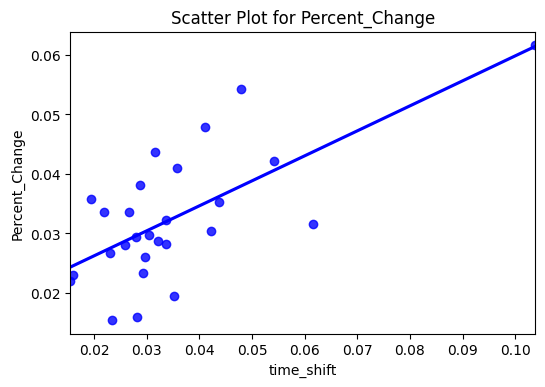

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     10.54
Date:                Tue, 15 Jun 2021   Prob (F-statistic):           0.000520
Time:                        16:54:17   Log-Likelihood:                 92.800
No. Observations:                  27   AIC:                            -179.6
Df Residuals:                      24   BIC:                            -175.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0215      0.007      3.293      0.0

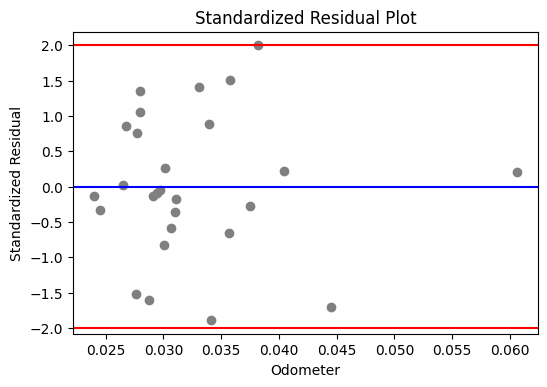

In [44]:
Auto_1.draw_shift()
Auto_1.autoregression_model_t()
Auto_1.check_condition()